# CIFAKE analysis of RAPSD

In [ ]:
!pip install -q deeplake
!pip install -q pysteps
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 79.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.9/589.9 kB 26.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is 

In [ ]:
import os
import time
import copy
import itertools
import shutil
import zipfile
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from scipy.signal import welch
from scipy.interpolate import interp1d
from skimage import io, color
from IPython.display import Audio, display
import tensorflow_datasets as tfds
import librosa
from pysteps.utils import spectral
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from datasets import load_dataset, concatenate_datasets
from google.colab import drive
drive.mount('/content/drive')
import kagglehub
# Configure matplotlib for animations
rc('animation', html='jshtml')

Mounted at /content/drive


In [ ]:
# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")

print("Path to dataset files:", path)

100%|██████████| 105M/105M [00:00<00:00, 114MB/s] 

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


In [ ]:
dataset_path = "/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3"

# List the files and directories
#for root, dirs, files in os.walk(dataset_path):
#    print(f"Root: {root}")
#    print(f"Directories: {dirs}")
#    print(f"Files: {files}")
#    print()

In [ ]:
cifake_path_fake = os.path.join(dataset_path, "train/FAKE")

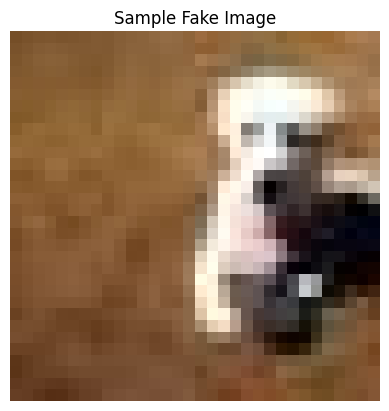

In [ ]:
# List all image files in train/FAKE
cifake_img_fake = [os.path.join(cifake_path_fake, img) for img in os.listdir(cifake_path_fake)]

# Display a sample image
sample_image_path = cifake_img_fake[0]  # First image in the folder
img = Image.open(sample_image_path)

plt.imshow(img)
plt.title("Sample Fake Image")
plt.axis("off")
plt.show()

In [ ]:
def resize_and_crop(image, smallest_side):
    height, width, num_channels = image.shape

    # Resize.
    if height <= width:
        new_height = smallest_side
        new_width = int(width * (new_height / height))
    else:
        new_width = smallest_side
        new_height = int(height * (new_width / width))

    image = cv2.resize(image, (new_width, new_height), interpolation=cv2.INTER_LINEAR)

    # Centre crop.
    offset_h = (new_height - smallest_side) // 2
    offset_w = (new_width - smallest_side) // 2

    return image[offset_h:offset_h + smallest_side, offset_w:offset_w + smallest_side, :]

In [ ]:
image_size = 32
num_examples = 5000
images_cifake_fake = []
for filepath in itertools.islice(cifake_img_fake, num_examples):
    if os.path.isfile(filepath):  # Ensure the file exists
        # Open the image
        img = Image.open(filepath).convert("RGB")  # Convert to RGB to handle all formats
        arr = np.array(img)
        arr = resize_and_crop(arr, image_size)  # Apply resize and crop
        images_cifake_fake.append(arr)
    else:
        print(f"File not found: {filepath}")

# Convert the list to a NumPy array
images_cifake_fake = np.array(images_cifake_fake)

In [ ]:
images_cifake_fake = (images_cifake_fake.astype(np.float32) / 255.0) * 2 - 1  # Scale and shift to [-1, 1].

In [ ]:
def calc_mean_log_rapsd_cifake(x):
  spectra = []
  for k in range(num_examples):
    rapsd, frequencies = spectral.rapsd(x[k, ...], fft_method=np.fft, return_freq=True)
    spectra.append(rapsd)

  mean_log_rapsd = np.mean(np.array([np.log(s + 1e-30) for s in spectra]), axis=0)
  return mean_log_rapsd, frequencies

0.038256741245257096


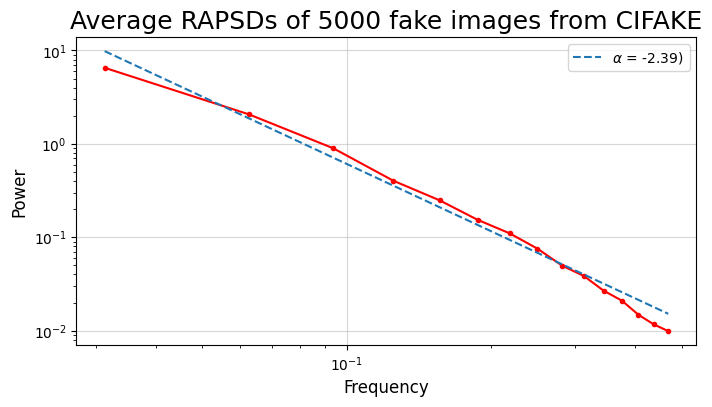

In [ ]:
# Plotting the log RAPSDs
mean_log_rapsd_cifake_fake, frequencies_cifake = calc_mean_log_rapsd_cifake(images_cifake_fake[..., 1])

# Getting the alpha exponent of powerlaw
log_frequencies_cifake = np.log(frequencies_cifake[1:])
equally_spaced_log_frequencies_cifake = np.linspace(log_frequencies_cifake[0], log_frequencies_cifake[-1], 1000)
interpolated_rapsd_cifake = np.interp(equally_spaced_log_frequencies_cifake, log_frequencies_cifake, mean_log_rapsd_cifake_fake[1:])
m_cifake, b_cifake = np.polyfit(equally_spaced_log_frequencies_cifake, interpolated_rapsd_cifake, 1)
linear_fit_cifake = m_cifake * equally_spaced_log_frequencies_cifake + b_cifake

# Residuals
mse_cifake = np.mean((linear_fit_cifake - interpolated_rapsd_cifake)**2)
print(mse_cifake)
residuals_mse_cifake = np.sqrt(mse_cifake)

# Plotting

plt.figure(figsize=(8, 4))
plt.title("Average RAPSDs of 5000 fake images from CIFAKE", fontsize = 18)
plt.plot(frequencies_cifake[1:], np.exp(mean_log_rapsd_cifake_fake)[1:], c='red', marker='o', markersize=3)
plt.plot(np.exp(equally_spaced_log_frequencies_cifake), np.exp(linear_fit_cifake), label=f'$\\alpha$ = {m_cifake:.2f})', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Power', fontsize = 12);


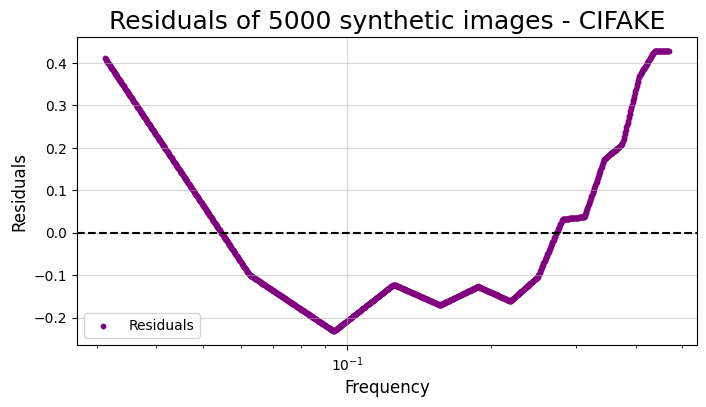

In [ ]:
# Plot residuals
plt.figure(figsize=(8, 4))
residuals_cifake_fake = linear_fit_cifake - interpolated_rapsd_cifake
plt.scatter(np.exp(equally_spaced_log_frequencies_cifake), residuals_cifake_fake, color='purple', label="Residuals", s=10)
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Residuals', fontsize = 12)
plt.title("Residuals of 5000 synthetic images - CIFAKE", fontsize = 18)

plt.grid(alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
print("Max residuals of CIFAKE:", max(residuals_cifake_fake))
print("Min residuals of CIFAKE:", min(residuals_cifake_fake))

Max residuals of CIFAKE: 0.4277770091237594
Min residuals of CIFAKE: -0.23167561261785818


# For real images of CIFAKE

In [ ]:
cifake_path_real = os.path.join(dataset_path, "train/REAL")

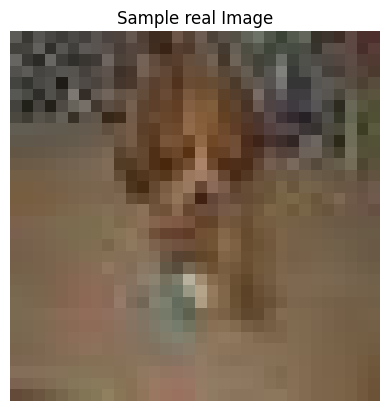

In [ ]:
# List all image files in train/FAKE
cifake_img_real = [os.path.join(cifake_path_real, img) for img in os.listdir(cifake_path_real)]

# Display a sample image
sample_image_path = cifake_img_real[0]  # First image in the folder
img = Image.open(sample_image_path)

plt.imshow(img)
plt.title("Sample real Image")
plt.axis("off")
plt.show()

In [ ]:
image_size = 32
num_examples = 5000
images_cifake_real = []
for filepath in itertools.islice(cifake_img_real, num_examples):
    if os.path.isfile(filepath):  # Ensure the file exists
        # Open the image
        img = Image.open(filepath).convert("RGB")  # Convert to RGB to handle all formats
        arr = np.array(img)
        arr = resize_and_crop(arr, image_size)  # Apply resize and crop
        images_cifake_real.append(arr)
    else:
        print(f"File not found: {filepath}")

# Convert the list to a NumPy array
images_cifake_real = np.array(images_cifake_real)

In [ ]:
images_cifake_real = (images_cifake_real.astype(np.float32) / 255.0) * 2 - 1  # Scale and shift to [-1, 1].

0.048258886709004016


Text(0, 0.5, 'Power')

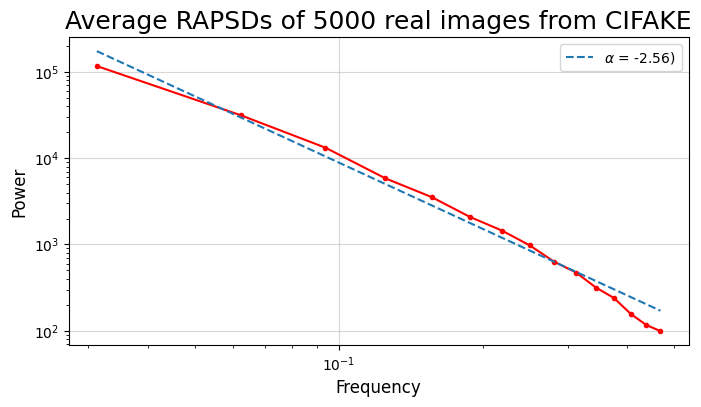

In [ ]:
# Plotting the log RAPSDs
mean_log_rapsd_cifake_real, frequencies_cifake_real = calc_mean_log_rapsd_cifake(images_cifake_real[..., 1])

# Getting the alpha exponent of powerlaw
log_frequencies_cifake_real = np.log(frequencies_cifake_real[1:])
equally_spaced_log_frequencies_cifake_real = np.linspace(log_frequencies_cifake_real[0], log_frequencies_cifake_real[-1], 1000)
interpolated_rapsd_cifake_real = np.interp(equally_spaced_log_frequencies_cifake_real, log_frequencies_cifake_real, mean_log_rapsd_cifake_real[1:])

m_cifake_real, b_cifake_real = np.polyfit(equally_spaced_log_frequencies_cifake_real, interpolated_rapsd_cifake_real, 1)
linear_fit_cifake_real = m_cifake_real * equally_spaced_log_frequencies_cifake_real + b_cifake_real

# Residuals
mse_cifake_real = np.mean((linear_fit_cifake_real - interpolated_rapsd_cifake_real)**2)
print(mse_cifake_real)
residuals_mse_cifake_real = np.sqrt(mse_cifake_real)

# Plotting

plt.figure(figsize=(8, 4))
plt.title("Average RAPSDs of 5000 real images from CIFAKE", fontsize = 18)
plt.plot(frequencies_cifake_real[1:], np.exp(mean_log_rapsd_cifake_real)[1:], c='red', marker='o', markersize=3)
plt.plot(np.exp(equally_spaced_log_frequencies_cifake_real), np.exp(linear_fit_cifake_real), label=f'$\\alpha$ = {m_cifake_real:.2f})', linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.grid(alpha = 0.5)
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Power', fontsize = 12)


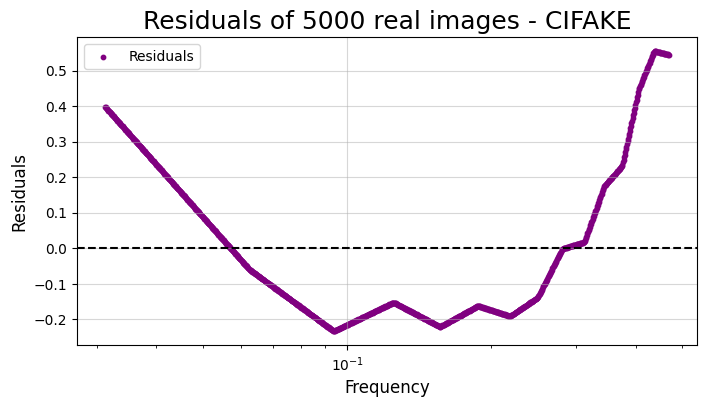

In [ ]:
# Plot residuals
plt.figure(figsize=(8, 4))
residuals_cifake_real = linear_fit_cifake_real - interpolated_rapsd_cifake_real
plt.scatter(np.exp(equally_spaced_log_frequencies_cifake_real), residuals_cifake_real, color='purple', label="Residuals", s=10)
plt.axhline(0, color='black', linestyle='--')
plt.xscale('log')
plt.xlabel('Frequency', fontsize = 12)
plt.ylabel('Residuals', fontsize = 12)
plt.title("Residuals of 5000 real images - CIFAKE", fontsize = 18)

plt.grid(alpha = 0.5)
plt.legend()
plt.show()

In [ ]:
print("Max residuals of CIFAKE:", max(residuals_cifake_real))
print("Min residuals of CIFAKE:", min(residuals_cifake_real))

Max residuals of CIFAKE: 0.554683210168049
Min residuals of CIFAKE: -0.2329675406310745


-----------------